<a href="https://colab.research.google.com/github/DaverArenas/procesamientoSe-alesInteligenciaArtificial/blob/main/Clase4E1_17_09_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Continuamos con el análisis de las series de tiempo.

En este ejercicio vamos a analizar lo anuncios vistos por hora y el dinero gastado por día en una aplicación móvil.

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 31.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd      
import numpy as np                                
import matplotlib.pyplot as plt
from itertools import product   # Permite crear una lista con todos los valores posibles entre os arreglos
from tqdm import tqdm_notebook  # Decorador de barra de progreso para iteradores
import seaborn as sbn
# Librerías de estadística y econometría
import statsmodels.formula.api as smf                                           # Creación de modelos a partir de formulas y df                                    
import statsmodels.tsa.api as smt                                               # Modelos para el análisis de series de tiempo SARIMAX
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
from pandas.tseries.offsets import DateOffset
import warnings

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize 

warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
ads = pd.read_csv('/content/drive/MyDrive/Especializacion BigData EIA/Procesamiento_Señales/Clase_4/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('/content/drive/MyDrive/Especializacion BigData EIA/Procesamiento_Señales/Clase_4/currency.csv', index_col=['Time'], parse_dates=['Time'])

In [10]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


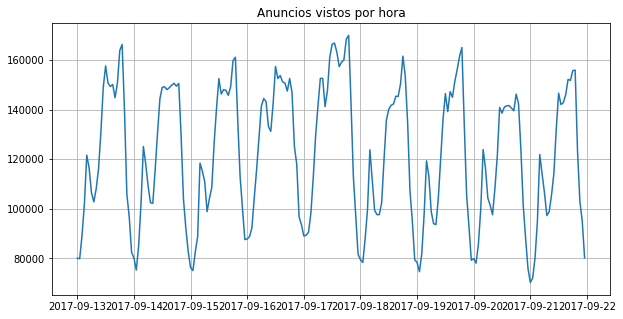

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(ads.Ads)
plt.title('Anuncios vistos por hora')
plt.grid(True)
plt.show()

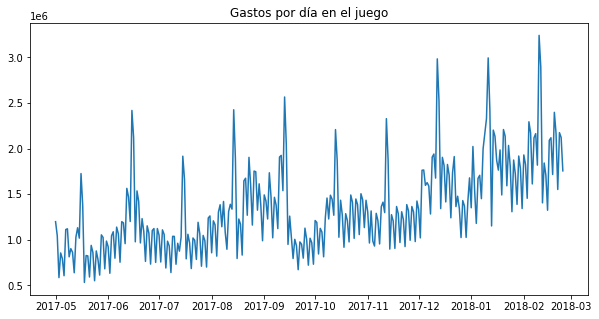

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Gastos por día en el juego')
plt.show()

# Análisis
Un factor importante es determinar si la serie de tiempo es estacionaria, es decir, que no cambia sus propiedades estadísticas con el tiempo.

Es importante conocer la estacionalidad puesto que se podría asumir que las propiedades estadísticas futuras no serán diferentes a las observadas.

La mayoría de los modelos de series de tiempo, tratan de predecir las propiedades de media o varianza.

Si la señal no es estacionaria las predicciones futuras serán erroneas. Sin embargo las señales en el mundo real no son estacionarias y vamos a revisar que pasa con estas.

## **Modelo ARIMA (autoregressive integrated moving average)**

Es un modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro. 

Se trata de un modelo dinámico de series temporales, es decir, las estimaciones futuras vienen explicadas por los datos del pasado y no por variables independientes.

Este modelo se utiliza donde hay evidecia de la no estacionalidad. 

Se debe diferenciar con respecto al modelo ARMA (modelo autorregresivo estacionario) el cual se aplica para describir una serie de tiempo estacionaria regular. 

En la función ```tsplot``` se gráfica la serie de tiempo con su función de autocorrelación y el cálculo del test de **Dickey-Fuller** que realiza una serie de diferencias aproximadas a partir del valor de ρ.

La hipótesis nula del Dickey-Fuller es que existe una raíz unitaria, con la alternativa de que no existe una raíz unitaria. Si el valor p > 0.05, entonces no podemos rechazar que haya una raíz unitaria.

Las raíces unitarias permiten identificar si la señal tiene un comportamiento estacionario. 

Si la raíz es igual a 1 la señal no es estacionaria, por el contrario, si hay raíces menores a uno el proceso es estacionario.


In [8]:
#y:Entrada de la señal, lags:retraso
def tsplot(y, lags=None, figsize=(10, 5)):
    """
        - Graficar la serie de tiempo con su función de autocorrelación, 
          la función de autocorrelación parcial y el cálculo del test de Dickey-Fuller
        - lags - cuántos retrasos se deben incluir en los calculos de autocorrelación
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    #Test para determinar si la función es estacionaria o no. Realizando el test Dickey-Fuller
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Análisis de serie de tiempo Gráfica\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

En la siguiente grafica podemos ver que p<0.05 por tanto esta señal es estacionaria 

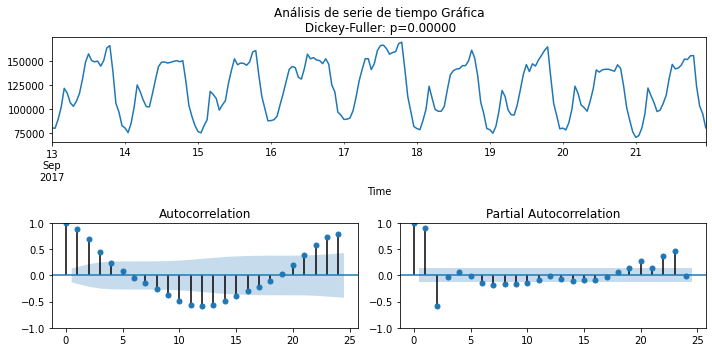

In [9]:
tsplot(ads.Ads)

En la siguiente grafica podemos ver que p>0.05 por tanto esta señal es NO 
estacionaria 

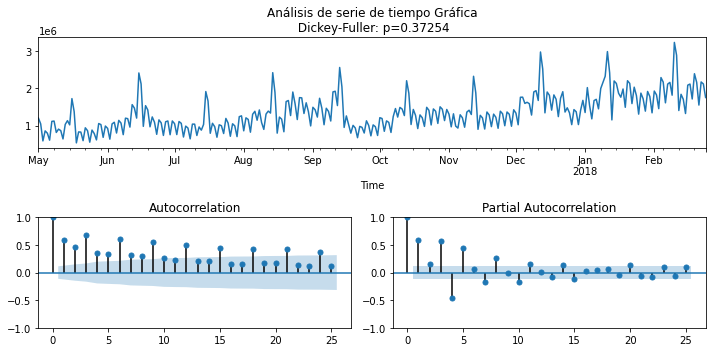

In [11]:
tsplot(currency.GEMS_GEMS_SPENT)

En este caso debemos realizar un proceso de diferenciación para volver la señal estacionaria. 


In [12]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

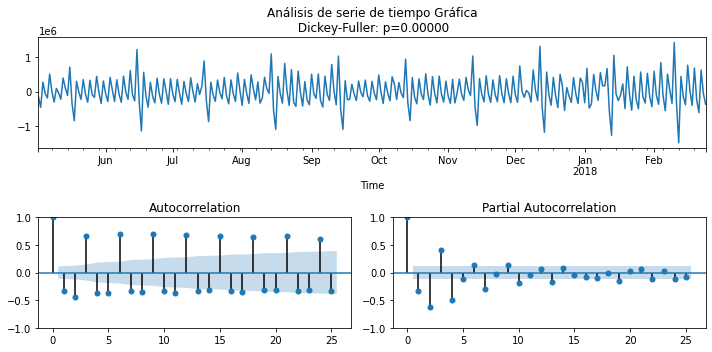

In [13]:
#Diferenciación para convertir la serie No estacionaria a estacionaria. Vamos a realizar una proceso similar a una Normalización
#Eliminamos el componente no estacionario dejando las medias constantes
newdf = pd.DataFrame(currency.GEMS_GEMS_SPENT.diff().dropna())
tsplot(newdf.GEMS_GEMS_SPENT)

Si posterior a esto, el test vuelve y falla, entonces tendriamos que aplicar una nueva diferenciación

In [ ]:
#Diferenciación para convertir la serie No estacionaria a estacionaria. Vamos a realizar una proceso similar a una Normalización
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

f = plt.figure(figsize=(40, 10))
ax1= f.add_subplot(121)
ax1.set_title('diferencia de primer orden')
ax1.plot(currency.GEMS_GEMS_SPENT.diff())
newdf = pd.DataFrame(currency.GEMS_GEMS_SPENT.diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(newdf, ax=ax2)
plt.show()

Con esta función podemos obtener un mejor ajuste. AIC es una medida de calidad relativa, a medida que se va ajustando mejor los parametros el valor AIC ira disminuyendo

In [15]:
def autoarima_params(y, max_p = 12, max_q = 12):
  model = pm.auto_arima(y, start_p=1, start_q=1,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=max_p, max_q=max_q, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

In [30]:
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


In [19]:
#Con este corremos el módelo sin la diferenciación. Es el original
autoarima_params(currency.GEMS_GEMS_SPENT)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8541.125, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9357.789, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8636.854, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9153.753, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8655.878, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8509.474, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9112.550, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8474.216, Time=0.29 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=8292.186, Time=0.91 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8396.362, Time=0.25 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=8293.523, Time=0.92 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=8298.895, Time=1.22 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8485.670, Time=0.39 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8376.684, Time=0.25 sec
 ARIMA(4,0,3)(0,0,0)[0]          

In [18]:
#Este es el modelo posterior a la diferenciación
autoarima_params(newdf.GEMS_GEMS_SPENT)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8513.617, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8610.460, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8577.431, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8521.165, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8355.154, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8429.499, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8344.867, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8376.130, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8292.697, Time=0.24 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8293.540, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=8282.425, Time=0.47 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8291.421, Time=0.15 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=8279.900, Time=0.40 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=8286.891, Time=0.19 sec
 ARIMA(7,0,1)(0,0,0)[0]          

##El mejor modelo de ajuste es p=7, d=0 (0 si no es necesario hacer la diferenciación, q=0 promedio de la media móvil)  

De acuerdo con las gráficas se puede observar que la primera señal es estacionaria, puesto que la prueba de Dickey-Fuller rechazó la hipótesis nula de que una raíz unitaria está presente. 

Para la segunda señal no se rechaza la hipótesis nula, quiere decir que es una seña no estacionaria. 

Por el momento vamos a continuar analizando la segunda señal.

## Definición


Los modelos ARIMA necesita identificar los coeficientes y número de regresiones que se utilizarán. Este modelo es muy sensible a la precisión con que se determinen sus coeficientes.

Se suele expresar como $ARIMA(p,d,q)$ donde los parámetros $p$, $d$ y $q$ son números enteros no negativos que indican el orden de las distintas componentes del modelo — respectivamente, las componentes autorregresiva, integrada y de media móvil. Cuando alguno de los tres parámetros es cero, es común omitir las letras correspondientes del acrónimo — AR para la componente autorregresiva, I para la integrada y MA para la media móvil. Por ejemplo, ARIMA(0,1,0) se puede expresar como I(1) y ARIMA(0,0,1) como MA(1).

El modelo ARIMA puede generalizarse aún más para considerar el efecto de la estacionalidad. En ese caso, se habla de un modelo SARIMA (seasonal autoregressive integrated moving average).


In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
p = 7
d = 0
q = 0

model = sm.tsa.ARIMA(newdf['GEMS_GEMS_SPENT'], order = (p,d,q))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        GEMS_GEMS_SPENT   No. Observations:                  299
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -4123.113
Date:                Sat, 17 Sep 2022   AIC                           8264.226
Time:                        14:10:08   BIC                           8297.530
Sample:                    05-02-2017   HQIC                          8277.555
                         - 02-24-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1862.7358   8159.483      0.228      0.819   -1.41e+04    1.79e+04
ar.L1         -0.0775      0.050     -1.564      0.118      -0.175       0.020
ar.L2         -0.5268      0.050    -10.615      0.000      -0.624      -0.430
ar.L3          0.0479      0.055      0.875      0.382      -0.059       0.155
ar.L4         -0.3739      0.049     -7.635      0.000      -0.470      -0.278
ar.L5         -0.2422      0.064     -3.770      0.000      -0.368      -0.116
ar.L6          0.1119      0.059      1.903      0.057      -0.003       0.227
ar.L7         -0.2905      0.058     -4.989      0.000      -0.405      -0.176
sigma2      5.579e+10      0.003   1.77e+13      0.000    5.58e+10    5.58e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               296.69
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                             0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+32. Standard errors may be unstable.
"""

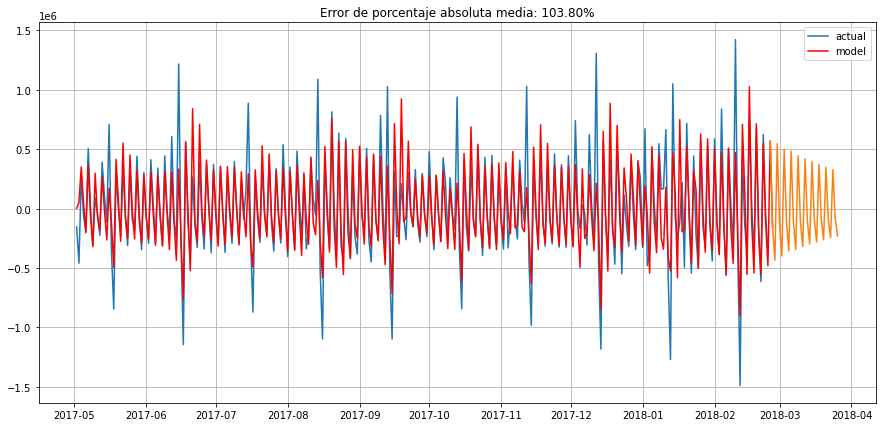

In [23]:
plt.figure(figsize=(15, 7))

plt.plot(newdf.GEMS_GEMS_SPENT, label="actual")
plt.plot(model_fit.predict(0, 300, dynamic=False), color='r', label="model")
plt.plot(model_fit.forecast(30, signal_only = True))
error = mean_absolute_percentage_error(newdf.GEMS_GEMS_SPENT, model_fit.predict(0, 300, dynamic=False))
plt.title("Error de porcentaje absoluta media: {0:.2f}%".format(error))
plt.legend()
plt.grid(True)

In [26]:
p = 5
d = 0
q = 3

model2 = sm.tsa.ARIMA(currency['GEMS_GEMS_SPENT'], order = (p,d,q))
model_fit2 = model2.fit()
model_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        GEMS_GEMS_SPENT   No. Observations:                  300
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -4114.085
Date:                Sat, 17 Sep 2022   AIC                           8248.170
Time:                        14:14:23   BIC                           8285.208
Sample:                    05-01-2017   HQIC                          8262.992
                         - 02-24-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.348e+06   3.41e-09   3.95e+14      0.000    1.35e+06    1.35e+06
ar.L1          0.8564      0.089      9.662      0.000       0.683       1.030
ar.L2         -0.2976      0.075     -3.969      0.000      -0.445      -0.151
ar.L3          0.9926      0.010     97.104      0.000       0.973       1.013
ar.L4         -0.8575      0.084    -10.166      0.000      -1.023      -0.692
ar.L5          0.2967      0.074      4.030      0.000       0.152       0.441
ma.L1          0.1227      0.093      1.315      0.188      -0.060       0.306
ma.L2          0.0618      0.098      0.630      0.529      -0.130       0.254
ma.L3         -0.7887      0.081     -9.709      0.000      -0.948      -0.629
sigma2      5.559e+10   1.46e-12    3.8e+22      0.000    5.56e+10    5.56e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               375.07
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.19e+37. Standard errors may be unstable.
"""

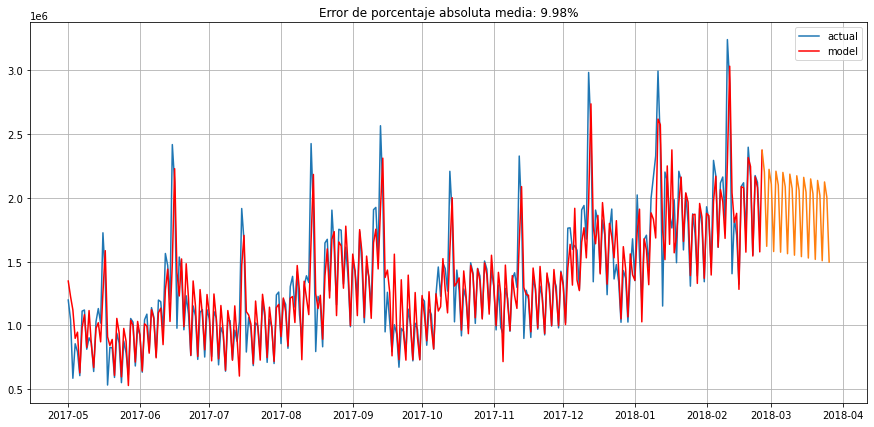

In [27]:
plt.figure(figsize=(15, 7))

plt.plot(currency.GEMS_GEMS_SPENT, label="actual")
plt.plot(model_fit2.predict(0, 300, dynamic=False), color='r', label="model")
plt.plot(model_fit2.forecast(30, signal_only = True))
error = mean_absolute_percentage_error(currency.GEMS_GEMS_SPENT, model_fit2.predict(0, 300, dynamic=False))
plt.title("Error de porcentaje absoluta media: {0:.2f}%".format(error))
plt.legend()
plt.grid(True)

In [28]:
model_fit2.predict(0, 300, dynamic=False)

2017-05-01    1.348372e+06
2017-05-02    1.226791e+06
2017-05-03    1.122030e+06
2017-05-04    8.991021e+05
2017-05-05    9.474355e+05
                  ...     
2018-02-21    1.544706e+06
2018-02-22    2.165957e+06
2018-02-23    2.082209e+06
2018-02-24    1.577162e+06
2018-02-25    2.373181e+06
Freq: D, Name: predicted_mean, Length: 301, dtype: float64

In [29]:
currency.GEMS_GEMS_SPENT

Time
2017-05-01    1199436
2017-05-02    1045515
2017-05-03     586111
2017-05-04     856601
2017-05-05     793775
               ...   
2018-02-20    2166449
2018-02-21    1552313
2018-02-22    2175548
2018-02-23    2122606
2018-02-24    1756394
Name: GEMS_GEMS_SPENT, Length: 300, dtype: int64

#Hacemos el mismo ejercicio con el siguiente Dataframe: Anuncios

In [31]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [33]:
autoarima_params(ads.Ads)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4608.593, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5684.857, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5530.857, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4594.616, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4596.601, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4592.119, Time=0.42 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4590.294, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5491.271, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4592.274, Time=0.36 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5479.773, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4570.543, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4811.0

In [34]:
p = 2
d = 0
q = 0

model3 = sm.tsa.ARIMA(ads['Ads'], order = (p,d,q))
model_fit3 = model3.fit()
model_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Ads   No. Observations:                  216
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2275.418
Date:                Sat, 17 Sep 2022   AIC                           4558.836
Time:                        14:23:12   BIC                           4572.337
Sample:                    09-13-2017   HQIC                          4564.291
                         - 09-21-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.22e+05   4278.432     28.509      0.000    1.14e+05     1.3e+05
ar.L1          1.4786      0.052     28.191      0.000       1.376       1.581
ar.L2         -0.6324      0.045    -13.983      0.000      -0.721      -0.544
sigma2      8.149e+07      0.785   1.04e+08      0.000    8.15e+07    8.15e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                25.52
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.80
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.65e+23. Standard errors may be unstable.
"""

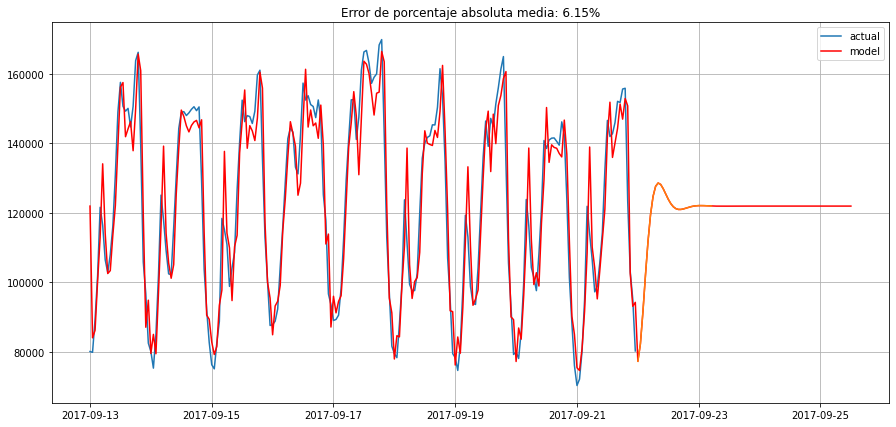

In [41]:
plt.figure(figsize=(15, 7))

plt.plot(ads.Ads, label="actual")
plt.plot(model_fit3.predict(0, 300, dynamic=False), color='r', label="model")
plt.plot(model_fit3.forecast(30, signal_only = True))
error = mean_absolute_percentage_error(ads.Ads, model_fit3.predict(0, 300, dynamic=False))
plt.title("Error de porcentaje absoluta media: {0:.2f}%".format(error))
plt.legend()
plt.grid(True)

DIFERENCIA ENTRE PREDICT VS FORECAST

## Modelo SARIMA
Ahora vamos a analizar con un modelo SARIMA la serie estacionaria. 
Para esto vamos a realizar una combinación de parámetros para el modelo

In [42]:
# estableciendo valores iniciales y algunos límites para ellos
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
# duración del análisis para este caso 24h
s = 24                                                                          

# crear lista con todas las combinaciones posibles de parámetros
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [46]:
def optimizeSARIMA(parameters_list, y, d, D, s):
    """
    Devuelve el dataframe con los parámetros y el AIC correspondiente
    parameters_list - lista con (p, q, P, Q) tuplas
    d - orden de integración en el modelo ARIMA
    D - orden de integración estacional 
    s - duración de la temporada
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # Ordenar los coeficientes de AIC de manera ascendente
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [48]:
%%time
result_table = optimizeSARIMA(parameters_list, ads.Ads, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 4min 22s, sys: 3min 29s, total: 7min 51s
Wall time: 4min 17s


In [49]:
#El mejor modelo es el que tiene parametros (2,3,1,1)
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


El modelo SARIMAX, además de tener los parámetros no estacionales, se le debe especificar el orden $P,Q,D,s$ el cual es el componente estacional para los parámetros AR, MA, y periodicidad. Normalmente el valor de 4 es para datos trimestrales o 12 para datos mensuales.



In [50]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Sat, 17 Sep 2022   AIC                           3888.642
Time:                                      15:55:18   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

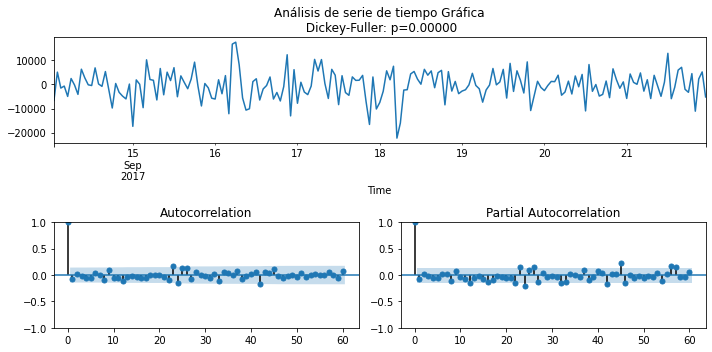

In [51]:
tsplot(best_model.resid[24+1:], lags=60)

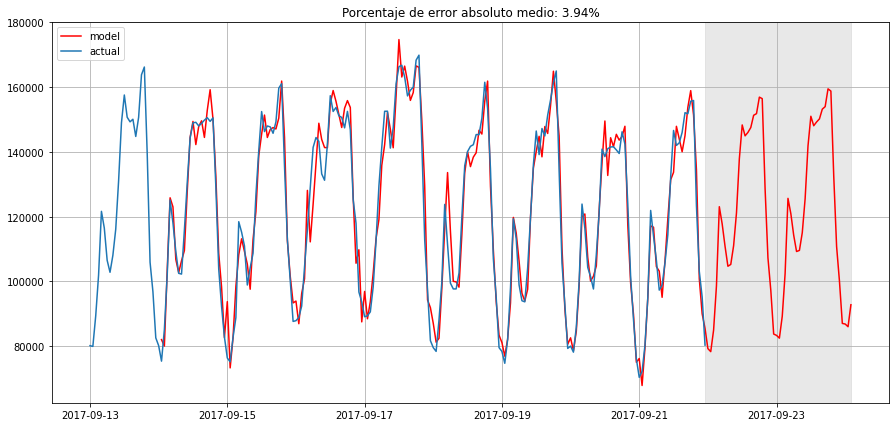

In [52]:
#Con esta función graficamos la serie con el pronostico(series=serie, model=modelo utilizado, n_steps= numero de pasos
def plotSARIMA(series, model, n_steps):
    """
        Gráfica de modelo vs valores predichos    
        series - dataset con series temporales
        modelo - modelo SARIMA ajustado
        n_steps - número de pasos a predecir en el futuro        
    """
    # añadiendo valores de modelo
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # haciendo un cambio en los pasos s+d, porque estos valores no fueron observados por el modelo
    # debido a la diferenciación
    data['arima_model'][:s+d] = np.NaN
    
    # pronosticando los n_pasos adelante
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calcular error, de nuevo habiendo cambiado los pasos de s+d desde el principio
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Porcentaje de error absoluto medio: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
plotSARIMA(ads, best_model, 50)

Con el modelo anterior se tenemos una nueva proyección hacia el futuro

In [54]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Sat, 17 Sep 2022   AIC                           3888.642
Time:                                      16:08:35   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

**Resumen**

* ARIMA: medias móviles integradas autorregresivas no estacionales
* SARIMA: ARIMA estacional
* SARIMAX: ARIMA estacional con variables exógenas


# Modelo HoltWinters

Es un método de suavización exponencial que permite elaborar pronósticos a corto plazo. También es utilizado para la detección de anomalías.
Para esto se debe establecer el modelo HoltWinter y la función de pérdida.

Para minimizar la función de pérdida, se debe elegir un algoritmo que soporte las restricciones de los parámetros del modelo. En este caso, usaremos el **Método Newton truncado**.

Este método consiste en la apilación repetida de un algoritmo de optimización para resolver iterativamente las ecuaciones de Newton. El solucionador interno es trucado, es decir, se ejecuta para un número limitado de iteraciones. 

[Más métodos de optimización](https://docs.scipy.org/doc/scipy/reference/optimize.html)

In [55]:
class HoltWinters:
    
    """
    Modelo Holt-Winters con detección de anomalías    
    series - Series de tiempo iniciales 
    slen - tamaño de análisis 
    alpha, beta, gamma - Holt-Winters coeficientes del modelo
    n_preds - horizonte de predicción
    scaling_factor - establece el ancho del intervalo de confianza (normalmente toma valores de 2 a 3)
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
         
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   
         
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [56]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    # arreglo de errores
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # Establecer el número de cortes para la validación cruzada
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iteración sobre cortes, modelo de tren en cada uno, previsión y cálculo de errores
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [59]:
%%time
# Datos para la prueba
data = ads.Ads[:-24]

# Inicialización de los parámetros del modelo alpha, beta and gamma
x = [0, 0, 0] 

# función de pérdida 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Se toman los valores óptimos
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# Se entrenaa el modelo con dichos valores, pronosticando para las próximas 50 horas
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50) #50 datos hacia adelante que vamos a predecir
model.triple_exponential_smoothing()

0.12844954930787766 0.003693391697852766 0.012988367880341134
CPU times: user 1.23 s, sys: 17.7 ms, total: 1.25 s
Wall time: 1.81 s


In [60]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset con la series de tiempo
        plot_intervals - gráfica intervalos de confianza
        plot_anomalies - gráfica las anomalías 
    """
    
    plt.figure(figsize=(10, 5))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Error de porcentaje absoluta media: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalíass")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

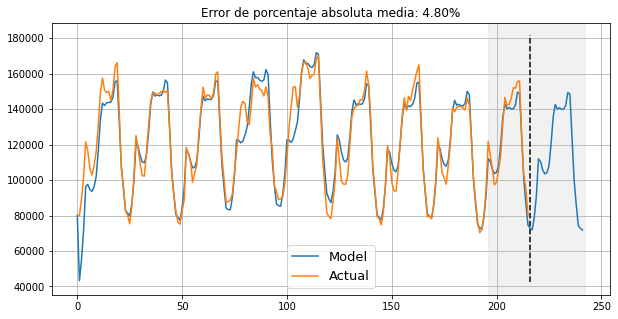

In [61]:
#Con un pronostico de 50 datos hacia adelante
plotHoltWinters(ads.Ads)

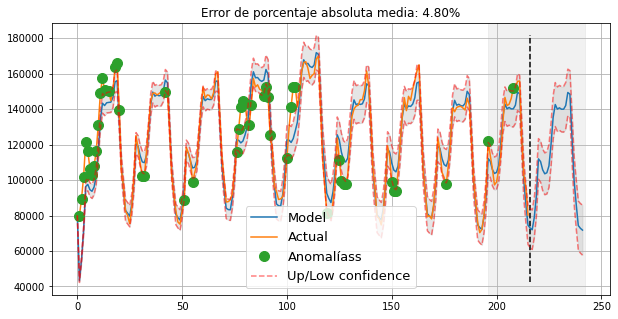

In [62]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

De acuerdo con la gráfica anterior, podemos decir que modelo fue capaz de aproximar con éxito la serie temporal inicial, capturando la estacionalidad diaria, la tendencia general a la baja, e incluso algunas anomalías. Si nos fijamos en las desviaciones del modelo, se puede ver claramente que el modelo reacciona muy bruscamente a los cambios en la estructura de la serie, pero luego devuelve rápidamente la desviación a los valores normales, esencialmente "olvidando" el pasado. Esta característica del modelo nos permite construir rápidamente sistemas de detección de anomalías, incluso para datos de series ruidosas, sin gastar demasiado tiempo en la preparación de los datos y la formación del modelo.

Ahora aplicamos el mismo algoritmo para la segunda serie para una estimación de 30 días

In [63]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 
x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              ) # TNC algoritmo de Newton truncado diseñados para optimizar 
                # funciones no lineales con un gran número de variables independientes 

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100) #, scaling_factor = 3)
model.triple_exponential_smoothing()

0.013190344846993662 0.047616267647338284 0.0
CPU times: user 2.32 s, sys: 14.8 ms, total: 2.33 s
Wall time: 2.32 s


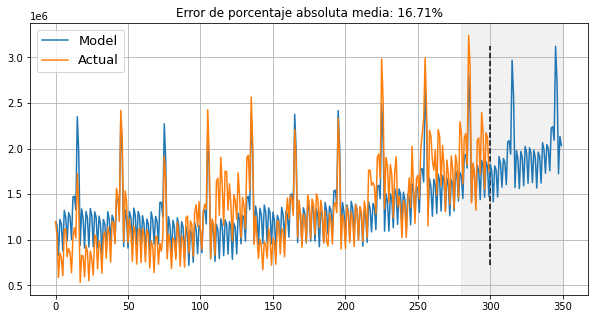

In [64]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

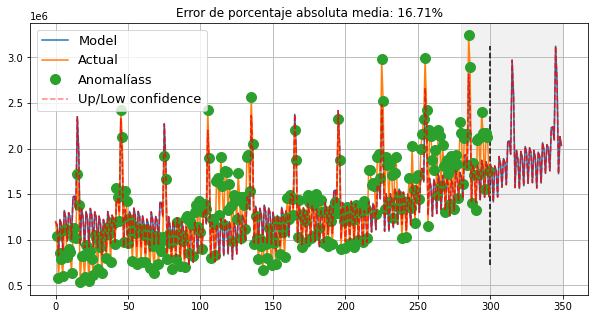

In [65]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

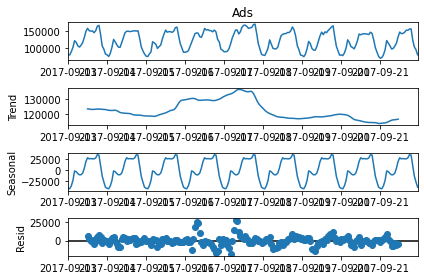

In [66]:
descomposicion = sm.tsa.seasonal_decompose(ads.Ads)
fig = descomposicion.plot()

In [67]:
descomposicion.trend

Time
2017-09-13 00:00:00   NaN
2017-09-13 01:00:00   NaN
2017-09-13 02:00:00   NaN
2017-09-13 03:00:00   NaN
2017-09-13 04:00:00   NaN
                       ..
2017-09-21 19:00:00   NaN
2017-09-21 20:00:00   NaN
2017-09-21 21:00:00   NaN
2017-09-21 22:00:00   NaN
2017-09-21 23:00:00   NaN
Name: trend, Length: 216, dtype: float64

In [68]:
descomposicion.seasonal

Time
2017-09-13 00:00:00   -41858.409288
2017-09-13 01:00:00   -43002.159288
2017-09-13 02:00:00   -36118.825955
2017-09-13 03:00:00   -23636.325955
2017-09-13 04:00:00    -1811.690538
                           ...     
2017-09-21 19:00:00    34568.817274
2017-09-21 20:00:00    10783.973524
2017-09-21 21:00:00   -13831.638455
2017-09-21 22:00:00   -27295.336372
2017-09-21 23:00:00   -39239.776476
Name: seasonal, Length: 216, dtype: float64